In [43]:
# opengrid imports
from opengrid.library import misc, houseprint, caching
from opengrid.library.analysis import DailyAgg
from opengrid import config
from opengrid.library.slack import Slack
from opengrid.library import alerts
c=config.Config()

# other imports
import pandas as pd
import json
import charts
import numpy as np
import os
import datetime as dt
import pytz
BXL = pytz.timezone('Europe/Brussels')


# configuration for the plots
DEV = c.get('env', 'type') == 'dev' # DEV is True if we are in development environment, False if on the droplet
print("Environment configured for development: {}".format(DEV))
if not DEV:
    # production environment: don't try to display plots
    import matplotlib
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, HourLocator, DateFormatter, AutoDateLocator, num2date

if DEV:
    if c.get('env', 'plots') == 'inline':
        %matplotlib inline
    else:
        %matplotlib qt
else:
    pass # don't try to render plots
plt.rcParams['figure.figsize'] = 12,8

Environment configured for development: True


In [24]:
hp = houseprint.Houseprint()
sensors = hp.get_sensors(sensortype='electricity') # sensor objects

# Remove some sensors
exclude = [
            '565de0a7dc64d8370aa321491217b85f' # 3E
          ]
solar = [x.key for x in hp.search_sensors(type='electricity', system='solar')]
exclude += solar

for s in sensors:
    if s.key in exclude:
        sensors.remove(s)

hp.init_tmpo()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
24 Sites created
24 Devices created
75 sensors created
Houseprint parsing complete
Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [25]:
hp.sync_tmpos()

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/connection.py:303: SubjectAltNameWarning: Certificate for api.flukso.net has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 fro

In [26]:
dt_now = pd.Timestamp('now', tz='UTC')
dt_start = dt_now - pd.Timedelta(hours=24)
df = hp.get_data(sensors=sensors, head=dt_start)

In [36]:
df_total = pd.DataFrame(df.sum()/60/1000)
df_total.columns=['sum']

Sort the daily consumptions

In [38]:
df_total.sort(columns=['sum'], axis=0, inplace=True)
df_total['percentile'] = np.array(range(len(df_total)))/float(len(df_total))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [39]:
df_total

,sum,percentile
214ef2d3533899dbf633caeb32e80483,0.970000,0.000000
156e0abc64b00c5e98dbd3c17883b5f6,1.285891,0.041667
2dd0f6942224767b18a411415f67b423,2.242987,0.083333
dfb719cc8240de810862228a7d1f37f3,2.868150,0.125000
e1dec16012edc11de998aeaa317274d7,2.973019,0.166667
cdd4808a8d0a228ba16fba7c66dda81a,2.975664,0.208333
77aaf550776560cd11eb68499b500075,5.209863,0.250000
81fb589c911e808daa96a2064bebed41,5.532440,0.291667
dd169cdc4479f7206007b536659e987e,6.316977,0.333333
d209e2bbb35b82b83cc0de5e8b84a4ff,6.933583,0.375000


# Setup percentile slack bot

In [40]:
slack_url = c.get('Slack', 'webhook')
username = 'PercentileBot'
channel = "junk" # we don't want to clutter up everything
emoji = ':warning:'
slack = Slack(url=slack_url, username=username, channel=channel, emoji=emoji)

# Setup absolute slack bot

In [41]:
slack_url = c.get('Slack', 'webhook')
username = 'AbsoluteBot'
channel = "junk" # we don't want to clutter up everything
emoji = ':warning:'
slack = Slack(url=slack_url, username=username, channel=channel, emoji=emoji)

# Create the alerts and send

In [44]:
alerts.create_alerts(df_total, hp, 'percentile_analysis', slack, column='percentile')
alerts.create_alerts(df_total, hp, 'absolute_analysis', slack, column='sum')

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning

# Attention, run this only once, to create a default alerts.cfg

In [34]:
threshhold = {
    "percentile_analysis":
         {"default":0.8,
          "3aa40023a1683bfec0f01cce8d45fc70":0.5
         },
 "absolute_analysis":
     {"default":25,
      "3aa40023a1683bfec0f01cce8d45fc70":10.5
     }
}

In [35]:

json.dump(threshhold, open("alerts.cfg", 'w'))

In [33]:
df_total

,sum,percentile,flm
214ef2d3533899dbf633caeb32e80483,0.970000,0.000000,FL03001251
156e0abc64b00c5e98dbd3c17883b5f6,1.285891,0.041667,FL03001441
2dd0f6942224767b18a411415f67b423,2.242987,0.083333,FL03001566
dfb719cc8240de810862228a7d1f37f3,2.868150,0.125000,FL03001566
e1dec16012edc11de998aeaa317274d7,2.973019,0.166667,FL03001561
cdd4808a8d0a228ba16fba7c66dda81a,2.975664,0.208333,FL03001556
77aaf550776560cd11eb68499b500075,5.209863,0.250000,FL03001266
81fb589c911e808daa96a2064bebed41,5.532440,0.291667,FL03001441
dd169cdc4479f7206007b536659e987e,6.316977,0.333333,FL03001553
d209e2bbb35b82b83cc0de5e8b84a4ff,6.933583,0.375000,FL03001572


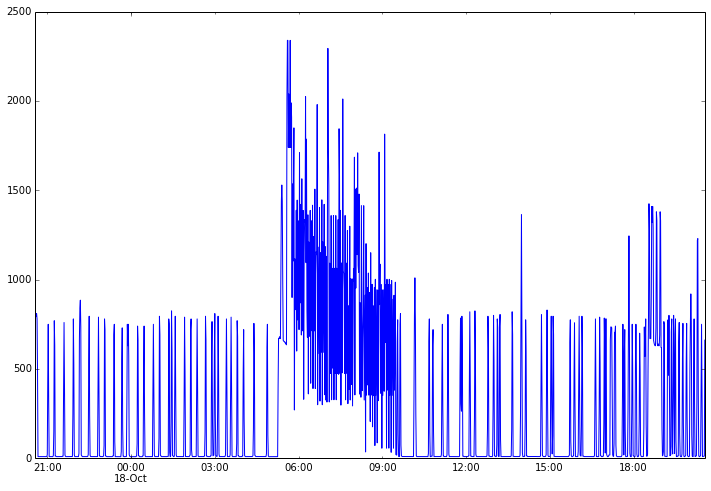

In [45]:
df['ad322ec64956ed232cb94a72517004ab'].plot()

In [46]:
fig = plt.gcf()

In [ ]:
fig.savefig()